In [3]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
# Load the saved model and tokenizer
loadstr = '/home/ubuntu/tlm-files/tlm/models/tlm-2025-08-05_16-42-11/checkpoint-10500/'
model = AutoModelForMaskedLM.from_pretrained(loadstr)
#tokenizer = BertTokenizerFast.from_pretrained('../coca_tokenized/tokenizer/')
tokenizer = AutoTokenizer.from_pretrained(loadstr)

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-11 21:36:19.465170: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-11 21:36:19.488386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757626579.516844   92069 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757626579.526195   92069 cuda_blas.cc:1407] Unable to 

In [4]:
import torch
import torch.nn.functional as F
def lyear(phrase, model, tokenizer):
    model.eval()

    years = list(range(1990, 2020))
    year_fills = ['[YEAR:{}]'.format(year) for year in years]
    year_fill_token_ids = [tokenizer.encode(e)[1] for e in year_fills]
    year_template = '[MASK] ' + phrase
    
    input_ids = tokenizer.encode(year_template, add_special_tokens=False, return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids=input_ids)
        logits = outputs.logits[0][0]
        year_sublogits = logits[year_fill_token_ids]
        year_subprobs = F.softmax(year_sublogits, dim=0)

    return years, year_sublogits, year_subprobs

In [5]:
from matplotlib import pyplot as plt
def pyear_given_slotfill(phrase, template, model, tokenizer, title, annotate=None, annotate_text=None, vlines=None, plot_template=False, plot_fill=False):
    years, fill_year_logits, fill_year_probs = lyear(phrase, model, tokenizer)
    _, template_year_logits, template_year_probs = lyear(template, model, tokenizer)
    bayes_factors = fill_year_probs/template_year_probs

    plt.figure()
    plt.title(title)
    plt.ylabel('Bayes Factor')
    plt.xlabel('Year')
    plt.plot(years, bayes_factors)
    plt.legend()

    if annotate != None:
        plt.axvspan(annotate[0], annotate[1], alpha=0.3, color='green')
        if annotate_text != None:
            plt.text(annotate[0], 0, annotate_text, ha='left', va='bottom')

    if vlines != None:
        for vline in vlines:
            plt.axvline(vline, color='red', linestyle='--')


    plt.show()

    if plot_fill:
        plt.plot(years, fill_year_probs, label='Fill')
        plt.legend()
        plt.show()

    if plot_template:
        plt.plot(years, template_year_probs, label='Template')
        plt.legend()
        plt.show()

    return bayes_factors

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


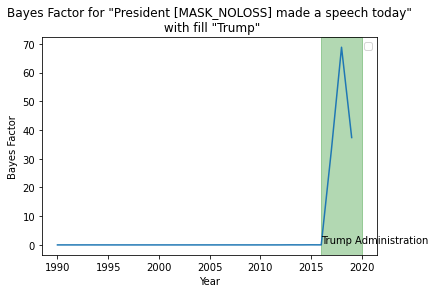

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


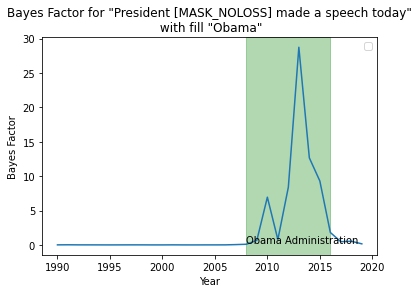

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


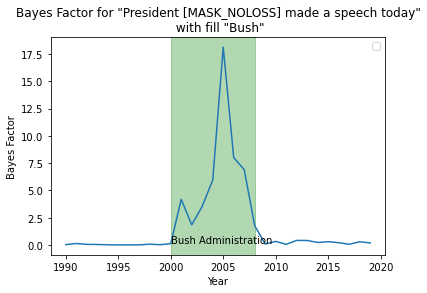

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


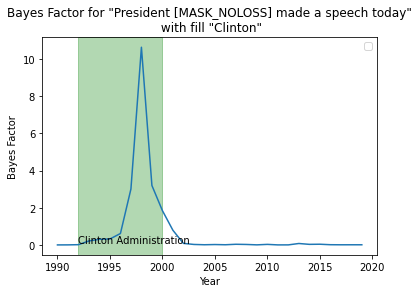

In [6]:
template = 'President [MASK_NOLOSS] made a speech today'
t_bayes = pyear_given_slotfill('President Trump made a speech today', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "Trump"',
 annotate=(2016, 2020), annotate_text='Trump Administration')
o_bayes = pyear_given_slotfill('President Obama made a speech today', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "Obama"',
 annotate=(2008, 2016), annotate_text='Obama Administration')
b_bayes = pyear_given_slotfill('President Bush made a speech today', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "Bush"',
 annotate=(2000, 2008), annotate_text='Bush Administration')
c_bayes = pyear_given_slotfill('President Clinton made a speech today', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "Clinton"',
 annotate=(1992, 2000), annotate_text='Clinton Administration')

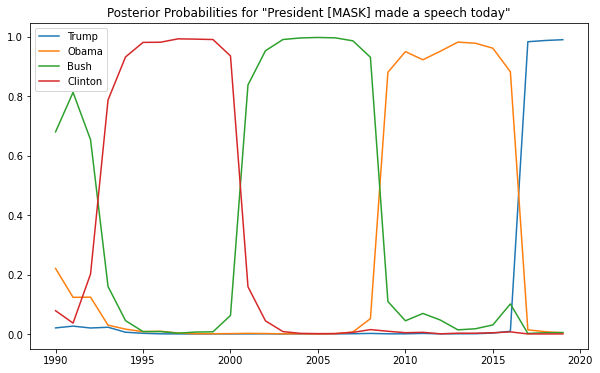

In [7]:
import numpy as np
all_bayes = np.stack([t_bayes, o_bayes, b_bayes, c_bayes])
posteriors = all_bayes/np.sum(all_bayes, axis=0)
years = list(range(1990, 2020))

plt.figure(figsize=(10, 6))
plt.title('Posterior Probabilities for "President [MASK] made a speech today"')
plt.plot(years, posteriors[0], label='Trump')
plt.plot(years, posteriors[1], label='Obama')
plt.plot(years, posteriors[2], label='Bush')
plt.plot(years, posteriors[3], label='Clinton')
plt.legend()
plt.show()

In [15]:
import torch
import torch.nn.functional as F
def l_fill(phrase, fill, model, tokenizer):
    model.eval()

    years = list(range(1990, 2020))
    phrases = ['[YEAR:{}]'.format(year) + ' ' + phrase for year in years]

    fill_token_ids = tokenizer.encode(fill, add_special_tokens=False)
    test_mask = tokenizer.encode(phrase, add_special_tokens=False, return_tensors='pt')
    n_masks = torch.where(test_mask==tokenizer.mask_token_id)[0].shape[0]
    if n_masks != len(fill_token_ids):
        raise ValueError(f"Number of mask tokens ({n_masks}) does not match number of fill token IDs ({len(fill_token_ids)})")
    
    inputs = tokenizer.batch_encode_plus(phrases, add_special_tokens=False, return_tensors='pt')
    mask_locs = torch.where(inputs['input_ids']==tokenizer.mask_token_id)

    with torch.no_grad():
        outputs = model(**inputs)
        fill_probs = []
        logits = outputs.logits[mask_locs]
        logits = logits.reshape(30, n_masks, -1)
        for i, fill_token_id in enumerate(fill_token_ids):
            fill_probs.append(F.softmax(logits[:, i, fill_token_id], dim=-1))

    return years, fill_probs

In [ ]:
_, clinton_fill_probs = l_fill('President [MASK] [MASK] made a speech today', 'Clinton', model, tokenizer)
_, trump_fill_probs = l_fill('President [MASK] made a speech today', 'Trump', model, tokenizer)
_, bush_fill_probs = l_fill('President [MASK] [MASK] made a speech today', 'Bush', model, tokenizer)
_, obama_fill_probs = l_fill('President [MASK] made a speech today', 'Obama', model, tokenizer)
_, potato_fill_probs = l_fill('President [MASK] [MASK] made a speech today', 'potato', model, tokenizer)

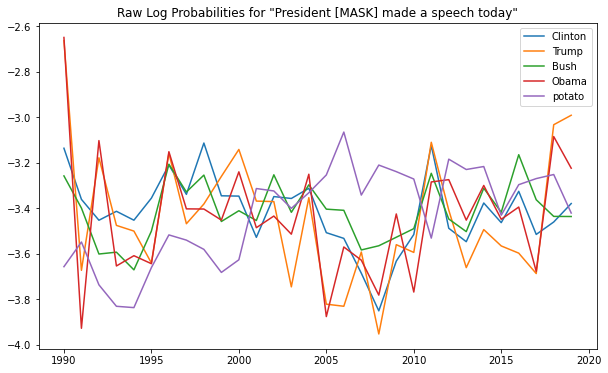

In [31]:
clinton_fill_logprobs = sum([np.log(e) for e in clinton_fill_probs])/len(clinton_fill_probs)
trump_fill_logprobs = sum([np.log(e) for e in trump_fill_probs])/len(trump_fill_probs)
bush_fill_logprobs = sum([np.log(e) for e in bush_fill_probs])/len(bush_fill_probs)
obama_fill_logprobs = sum([np.log(e) for e in obama_fill_probs])/len(obama_fill_probs)
potato_fill_logprobs = sum([np.log(e) for e in potato_fill_probs])/len(potato_fill_probs)

plt.figure(figsize=(10, 6))
plt.title('Raw Log Probabilities for "President [MASK] made a speech today"')
plt.plot(years, clinton_fill_logprobs, label='Clinton')
plt.plot(years, trump_fill_logprobs, label='Trump')
plt.plot(years, bush_fill_logprobs, label='Bush')
plt.plot(years, obama_fill_logprobs, label='Obama')
plt.plot(years, potato_fill_logprobs, label='potato')
plt.legend()
plt.show()

